### **Importing Libraries**


In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### **Downloading the dataset**

In [2]:
# Upload kaggle.jason
from google.colab import files
files.upload()

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/moltean/fruits'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: brianwong778
Your Kaggle Key: ··········


100%|██████████| 1.28G/1.28G [00:15<00:00, 91.7MB/s]


### **Loading up the training and testing data**

In [3]:
data_dir = 'fruits/fruits-360_dataset/fruits-360'
test_dir = data_dir + '/Test'
train_dir = data_dir + '/Training'
classes = os.listdir(train_dir)
classes.sort()
print(classes)
len(classes)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

131

In [4]:
train_dataset = ImageFolder(data_dir + '/Training', transform=ToTensor())
test_dataset = ImageFolder(data_dir + '/Test', transform=ToTensor())

print(train_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 67692
    Root location: fruits/fruits-360_dataset/fruits-360/Training
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 22688
    Root location: fruits/fruits-360_dataset/fruits-360/Test
    StandardTransform
Transform: ToTensor()


### **Here's all the classes in the dataset:**

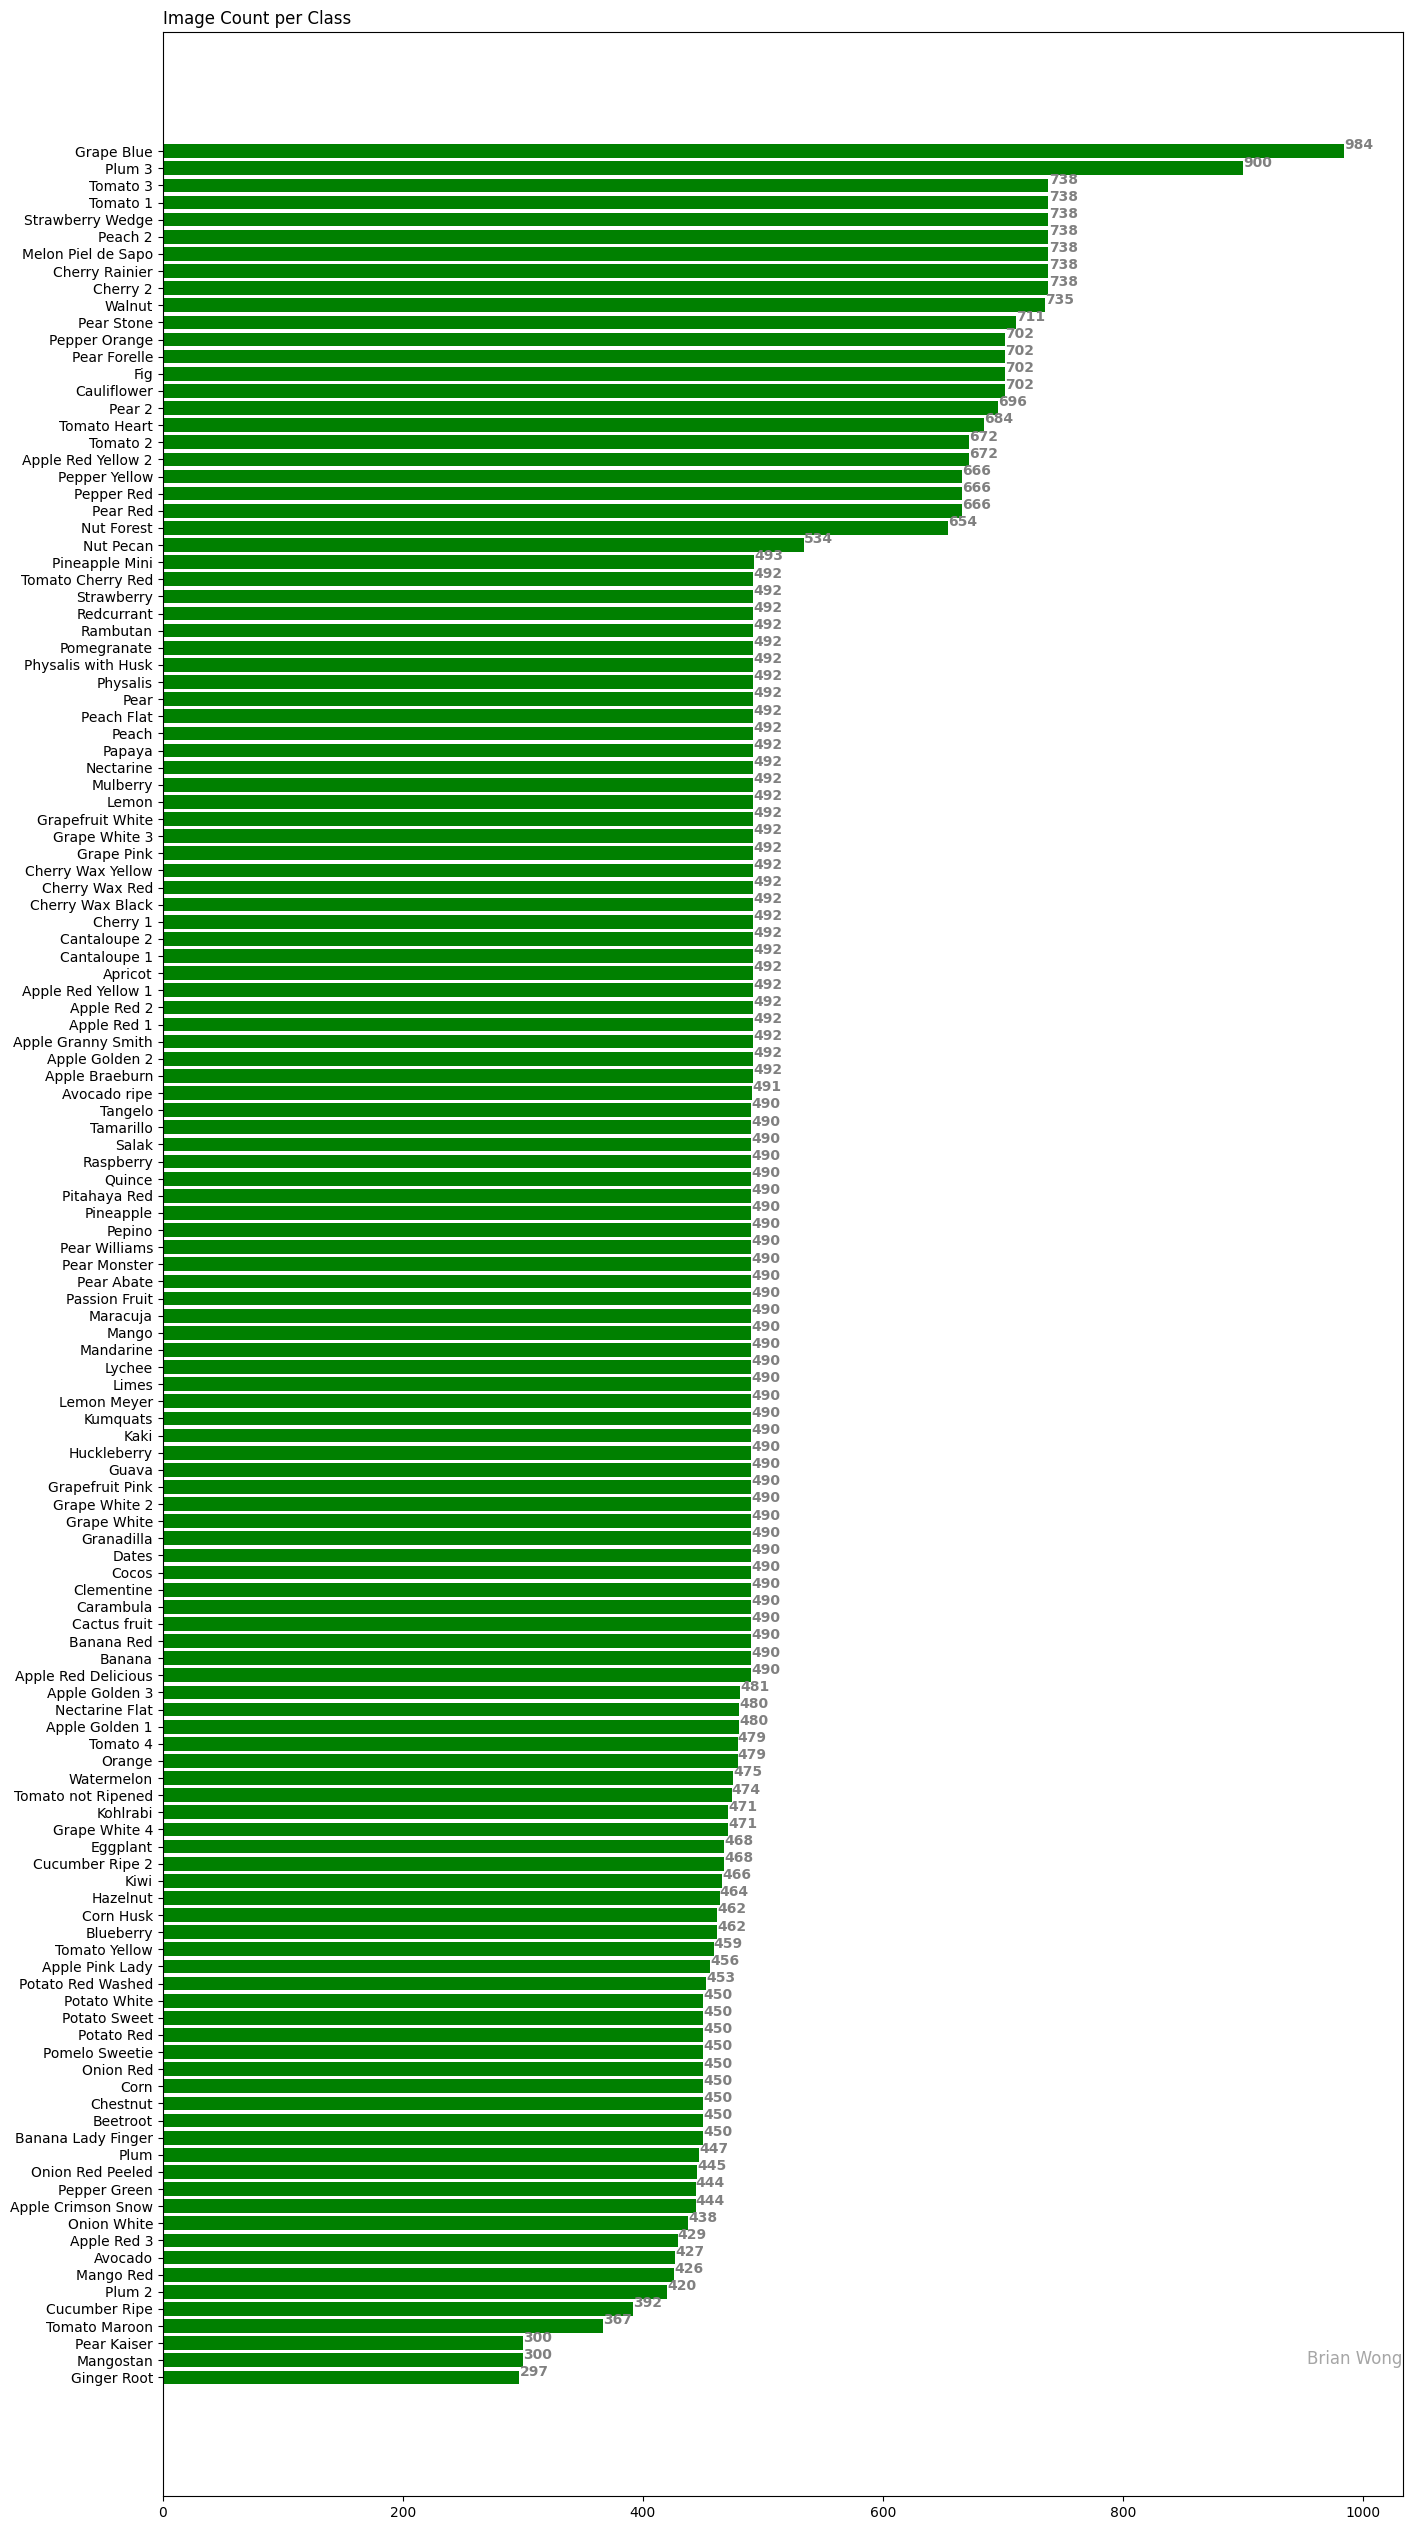

In [5]:
total_images = len(train_dataset)
class_names = train_dataset.classes
total_classes = len(class_names)

# Initialize a dictionary to count images per class
image_count = {}
for _, label in train_dataset:
    class_name = class_names[label]
    if class_name in image_count:
        image_count[class_name] += 1
    else:
        image_count[class_name] = 1

# Order the classes by their image count in ascending order
ordered_image_count = sorted(image_count.items(), key=lambda x: x[1])
ordered_image_count = dict(ordered_image_count)

# Creating a horizontal bar chart
fig, chart = plt.subplots(figsize=(16, 32))
chart.barh(list(ordered_image_count.keys()), list(ordered_image_count.values()), color='green')

chart.set_title('Image Count per Class', loc='left')

# Adding text to the bars
for bar in chart.patches:
    chart.text(bar.get_width() + 0.2, bar.get_y() + 0.5,
               f'{round(bar.get_width(), 2)}',
               fontsize=10, fontweight='bold', color='grey')

# Adding author text
fig.text(0.9, 0.15, 'Brian Wong', fontsize=12, color='grey', ha='right', va='bottom', alpha=0.7)

plt.show()




### **A few examples:**

In [6]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Apple Golden 1 (2)


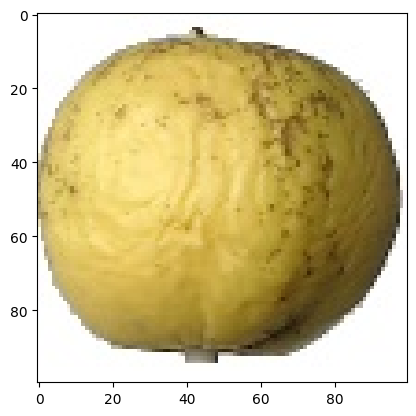

In [7]:
show_example(*train_dataset[1000])

Label:  Banana (16)


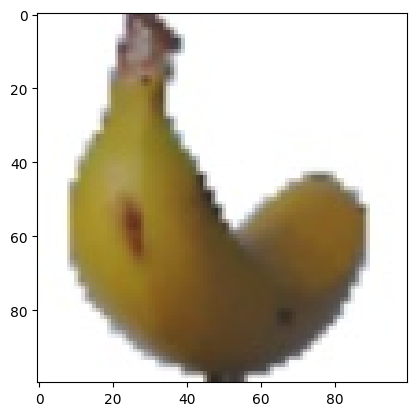

In [8]:
show_example(*train_dataset[8000])

Label:  Eggplant (40)


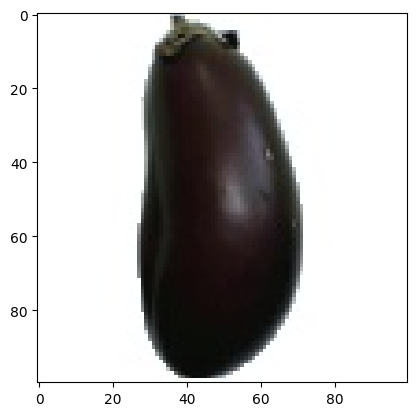

In [9]:
show_example(*train_dataset[20000])

### **Data Transformation**

In [10]:
train_data_transforms = tt.Compose([
    tt.RandomResizedCrop(100, scale=(0.8, 1.0)),  # Random resized cropping to 100x100 pixels
    tt.RandomHorizontalFlip(p=0.5),              # horizontal flip with 50% probability
    tt.RandomRotation(degrees=15),               # Random rotation by +/- 15 degrees
    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Adjusting color properties
    tt.ToTensor(),                              # Converting images to PyTorch tensors
])

test_data_transforms = tt.Compose([
    tt.Resize((100, 100)),  # Resize images to 100x100 pixels for consistency
    tt.ToTensor(),         # Convert images to tensors
])



In [11]:
aug_dataset = ImageFolder(data_dir + "/Training", transform=train_data_transforms)

test_dataset = ImageFolder(data_dir + "/Test", transform=test_data_transforms)

### **Creating the validation set**

In [12]:
random_seed = 17
torch.manual_seed(random_seed);

# Number of samples to set aside for validation
val_size = 12000
train_size = len(aug_dataset) - val_size

# Splitting the dataset into training and validation sets
train_ds, val_ds = random_split(aug_dataset, [train_size, val_size])

len(train_ds), len(val_ds)


(55692, 12000)

In [13]:
from torch.utils.data.dataloader import DataLoader
batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

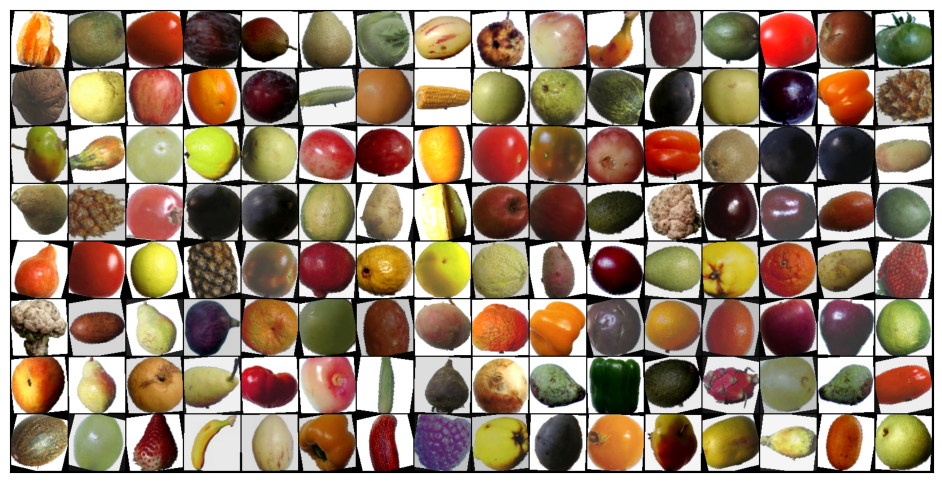

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

### **Set up for device type**


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### **Configuring the CNN Model**

In [ ]:
batch_size = 128
learning_rate = 0.001

input_size = 3*100*100
output_size = 131

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # loss
        acc = accuracy(out, labels)           # accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

**An old model with 84% accuracy after 10 epochs, and is overfitting**

In [ ]:
'''

class FruitsModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # First Convolution Block
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # Output: 32 X 50 X 50

            # Second Convolution Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # Output: 64 X 25 X 25

            # Third Convolution Block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2), # Output: 128 X 12 X 12

            # Adaptive Pooling
            nn.AdaptiveAvgPool2d((1, 1)), # Global Average Pooling

            # Flattening the layers
            nn.Flatten(),

            # Fully Connected Layer
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 131) # Output layer with 131 classes
        )

    def forward(self, xb):
        return self.network(xb)
'''

In [17]:
class FruitsModel(ImageClassificationBase): #98% accuracy after 35 epochs
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # First Convolution Block
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Second Convolution Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Third Convolution Block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Adaptive Pooling
            nn.AdaptiveAvgPool2d((1, 1)),

            # Flattening
            nn.Flatten(),

            # Fully Connected Layer
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 131)
        )

    def forward(self, xb):
        return self.network(xb)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model = FruitsModel()
model

FruitsModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (1

### **Training**

In [ ]:
model = to_device(FruitsModel(), device)

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

from tqdm import tqdm

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', unit='batch'):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history


In [ ]:
os.environ['WANDB_CONSOLE'] = 'off'

history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.875861644744873, 'val_acc': 0.0071119870990514755}]

**Starting with 25 epochs**

In [ ]:
epochs = 25
lr = 0.01
opt_func = torch.optim.Adam

# Timing the training process
import time
start_time = time.time()

# Training the model
history += fit(epochs, lr, model, train_dl, val_dl, opt_func=opt_func)

# Printing the time taken
end_time = time.time()
print("Training time: {:.2f}s".format(end_time - start_time))


Epoch 1/25: 100%|██████████| 436/436 [02:10<00:00,  3.34batch/s]


Epoch [0], train_loss: 2.4456, val_loss: 1.8610, val_acc: 0.4229


Epoch 2/25: 100%|██████████| 436/436 [02:08<00:00,  3.39batch/s]


Epoch [1], train_loss: 1.5798, val_loss: 3.2904, val_acc: 0.2711


Epoch 3/25: 100%|██████████| 436/436 [02:08<00:00,  3.39batch/s]


Epoch [2], train_loss: 1.1626, val_loss: 1.3140, val_acc: 0.5868


Epoch 4/25: 100%|██████████| 436/436 [02:09<00:00,  3.35batch/s]


Epoch [3], train_loss: 0.8750, val_loss: 0.7303, val_acc: 0.7581


Epoch 5/25: 100%|██████████| 436/436 [02:11<00:00,  3.32batch/s]


Epoch [4], train_loss: 0.6668, val_loss: 0.4747, val_acc: 0.8365


Epoch 6/25: 100%|██████████| 436/436 [02:06<00:00,  3.45batch/s]


Epoch [5], train_loss: 0.5350, val_loss: 0.6696, val_acc: 0.7737


Epoch 7/25: 100%|██████████| 436/436 [02:05<00:00,  3.46batch/s]


Epoch [6], train_loss: 0.4469, val_loss: 0.3024, val_acc: 0.8955


Epoch 8/25: 100%|██████████| 436/436 [02:05<00:00,  3.48batch/s]


Epoch [7], train_loss: 0.3737, val_loss: 0.4801, val_acc: 0.8481


Epoch 9/25: 100%|██████████| 436/436 [02:04<00:00,  3.49batch/s]


Epoch [8], train_loss: 0.3177, val_loss: 0.5865, val_acc: 0.8210


Epoch 10/25: 100%|██████████| 436/436 [02:05<00:00,  3.48batch/s]


Epoch [9], train_loss: 0.2978, val_loss: 1.5280, val_acc: 0.6565


Epoch 11/25: 100%|██████████| 436/436 [02:04<00:00,  3.50batch/s]


Epoch [10], train_loss: 0.2435, val_loss: 1.9544, val_acc: 0.6306


Epoch 12/25: 100%|██████████| 436/436 [02:04<00:00,  3.50batch/s]


Epoch [11], train_loss: 0.2245, val_loss: 0.1684, val_acc: 0.9433


Epoch 13/25: 100%|██████████| 436/436 [02:04<00:00,  3.50batch/s]


Epoch [12], train_loss: 0.2001, val_loss: 0.2657, val_acc: 0.9119


Epoch 14/25: 100%|██████████| 436/436 [02:05<00:00,  3.48batch/s]


Epoch [13], train_loss: 0.2026, val_loss: 0.9450, val_acc: 0.7499


Epoch 15/25: 100%|██████████| 436/436 [02:04<00:00,  3.50batch/s]


Epoch [14], train_loss: 0.1823, val_loss: 0.6123, val_acc: 0.8325


Epoch 16/25: 100%|██████████| 436/436 [02:04<00:00,  3.50batch/s]


Epoch [15], train_loss: 0.1679, val_loss: 0.1437, val_acc: 0.9523


Epoch 17/25: 100%|██████████| 436/436 [02:05<00:00,  3.46batch/s]


Epoch [16], train_loss: 0.1676, val_loss: 0.0661, val_acc: 0.9792


Epoch 18/25: 100%|██████████| 436/436 [02:07<00:00,  3.43batch/s]


Epoch [17], train_loss: 0.1377, val_loss: 0.1994, val_acc: 0.9338


Epoch 19/25: 100%|██████████| 436/436 [02:06<00:00,  3.45batch/s]


Epoch [18], train_loss: 0.1435, val_loss: 0.1049, val_acc: 0.9652


Epoch 20/25: 100%|██████████| 436/436 [02:06<00:00,  3.44batch/s]


Epoch [19], train_loss: 0.1507, val_loss: 0.1439, val_acc: 0.9542


Epoch 21/25: 100%|██████████| 436/436 [02:08<00:00,  3.39batch/s]


Epoch [20], train_loss: 0.1312, val_loss: 0.1502, val_acc: 0.9492


Epoch 22/25: 100%|██████████| 436/436 [02:07<00:00,  3.42batch/s]


Epoch [21], train_loss: 0.1352, val_loss: 0.1534, val_acc: 0.9465


Epoch 23/25: 100%|██████████| 436/436 [02:06<00:00,  3.46batch/s]


Epoch [22], train_loss: 0.1159, val_loss: 0.0850, val_acc: 0.9719


Epoch 24/25: 100%|██████████| 436/436 [02:04<00:00,  3.49batch/s]


Epoch [23], train_loss: 0.1177, val_loss: 0.0970, val_acc: 0.9699


Epoch 25/25: 100%|██████████| 436/436 [02:05<00:00,  3.47batch/s]


Epoch [24], train_loss: 0.1147, val_loss: 0.0711, val_acc: 0.9793
Training time: 3849.51s


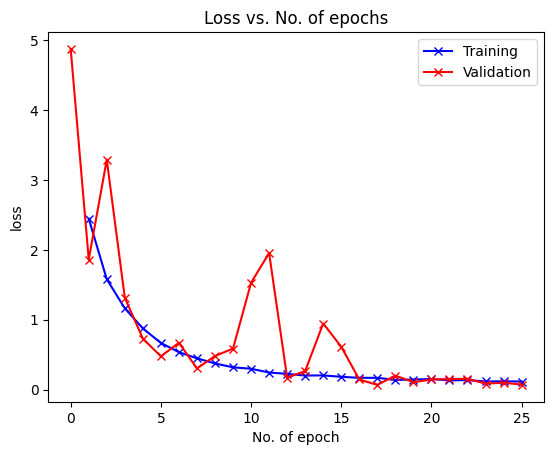

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('No. of epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)


**About 97% accuracy after 25 epochs, Training and Validation loss have converged, so there's no overfitting. Trying with another 10 epochs:**

In [ ]:
# Additional epochs to train
additional_epochs = 10

additional_start_time = time.time()
history += fit(additional_epochs, lr, model, train_dl, val_dl, opt_func=opt_func)

additional_end_time = time.time()

# Printing the time taken for the additional training
print("Additional training time: {:.2f}s".format(additional_end_time - additional_start_time))


Epoch 1/10: 100%|██████████| 436/436 [02:05<00:00,  3.46batch/s]


Epoch [0], train_loss: 0.1130, val_loss: 0.0814, val_acc: 0.9743


Epoch 2/10: 100%|██████████| 436/436 [02:05<00:00,  3.48batch/s]


Epoch [1], train_loss: 0.1068, val_loss: 0.0786, val_acc: 0.9759


Epoch 3/10: 100%|██████████| 436/436 [02:05<00:00,  3.48batch/s]


Epoch [2], train_loss: 0.1061, val_loss: 0.0583, val_acc: 0.9817


Epoch 4/10: 100%|██████████| 436/436 [02:05<00:00,  3.47batch/s]


Epoch [3], train_loss: 0.1014, val_loss: 0.0768, val_acc: 0.9757


Epoch 5/10: 100%|██████████| 436/436 [02:04<00:00,  3.50batch/s]


Epoch [4], train_loss: 0.0903, val_loss: 0.0587, val_acc: 0.9826


Epoch 6/10: 100%|██████████| 436/436 [02:04<00:00,  3.50batch/s]


Epoch [5], train_loss: 0.0927, val_loss: 0.0480, val_acc: 0.9854


Epoch 7/10: 100%|██████████| 436/436 [02:04<00:00,  3.49batch/s]


Epoch [6], train_loss: 0.0898, val_loss: 0.0440, val_acc: 0.9887


Epoch 8/10: 100%|██████████| 436/436 [02:05<00:00,  3.47batch/s]


Epoch [7], train_loss: 0.0772, val_loss: 0.0371, val_acc: 0.9883


Epoch 9/10: 100%|██████████| 436/436 [02:05<00:00,  3.47batch/s]


Epoch [8], train_loss: 0.0821, val_loss: 0.0734, val_acc: 0.9778


Epoch 10/10: 100%|██████████| 436/436 [02:04<00:00,  3.50batch/s]


Epoch [9], train_loss: 0.0912, val_loss: 0.0340, val_acc: 0.9895
Additional training time: 1529.07s


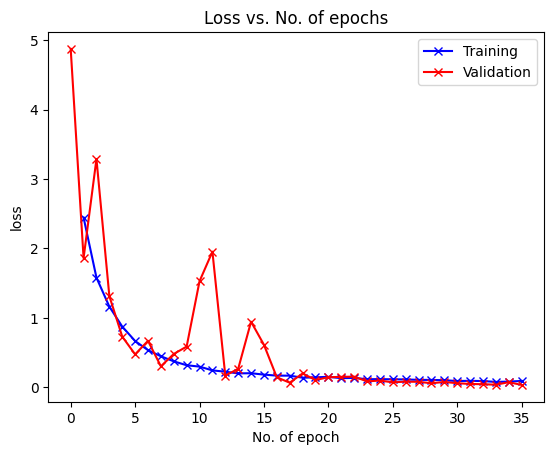

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('No. of epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

**98% accuracy after 35 epochs. Training and Validation loss haven't diverged, so it seems like the model is perfoming well at this point.**

In [ ]:
test_tfms = tt.Compose([tt.Resize((100, 100)),
                        tt.ToTensor()])

In [ ]:
test_dataset = ImageFolder(data_dir + "/Test", transform=test_tfms)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.07150990515947342, 'val_acc': 0.9849455952644348}

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_dataset.classes[preds[0].item()]

Label: Potato Red Washed Predicted: Potato Red Washed


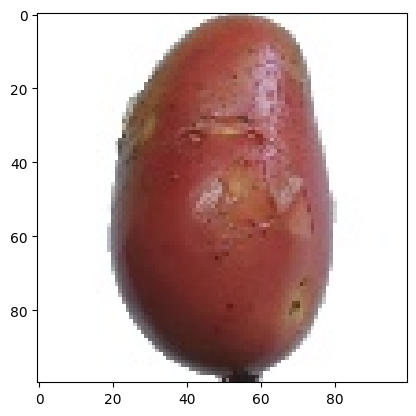

In [ ]:
img, label = test_dataset[18565]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], 'Predicted:', predict_image(img, model))

### **Saving the model**

In [ ]:
torch.save(model.state_dict(), 'fruits_model.pth')